In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind
from scipy import stats
from matplotlib.gridspec import GridSpec
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
import statsmodels.api as sm
from statsmodels.formula.api import ols


Import and clean data

In [ ]:
df = pd.read_csv("Data/Salinité + Hauteur d’eau + pH + redox + OD - paramètres environnementaux  - Feuille 5.csv")  # Remplace par le nom exact de ton fichier
df = df.iloc[:, 1:]

df["Salinité à -30cm"] = df["Salinité à -30cm"].astype(str).str.replace(',', '.')
df["Profondeur de la nappe"] = df["Profondeur de la nappe"].astype(str).str.replace(',', '.')

df = df[
    df["Salinité à -30cm"].str.replace('.', '', 1).str.isnumeric() &
    df["Profondeur de la nappe"].str.replace('-', '', 1).str.replace('.', '', 1).str.isnumeric()
]

df["Salinité à -30cm"] = df["Salinité à -30cm"].astype(float)
df["Profondeur de la nappe"] = df["Profondeur de la nappe"].astype(float)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df["Station"] = df["Parcelle"].str.extract(r'([A-Z]+)')


stations = ["RB", "RH", "T", "A"]
dates = sorted(df["Date"].unique())
df

[Timestamp('2025-03-30 00:00:00'),
 Timestamp('2025-04-10 00:00:00'),
 Timestamp('2025-04-16 00:00:00'),
 Timestamp('2025-04-22 00:00:00'),
 Timestamp('2025-04-30 00:00:00'),
 Timestamp('2025-05-07 00:00:00'),
 Timestamp('2025-05-14 00:00:00')]

Plot salinity at 30 cm depth as a function of date, grouped by station

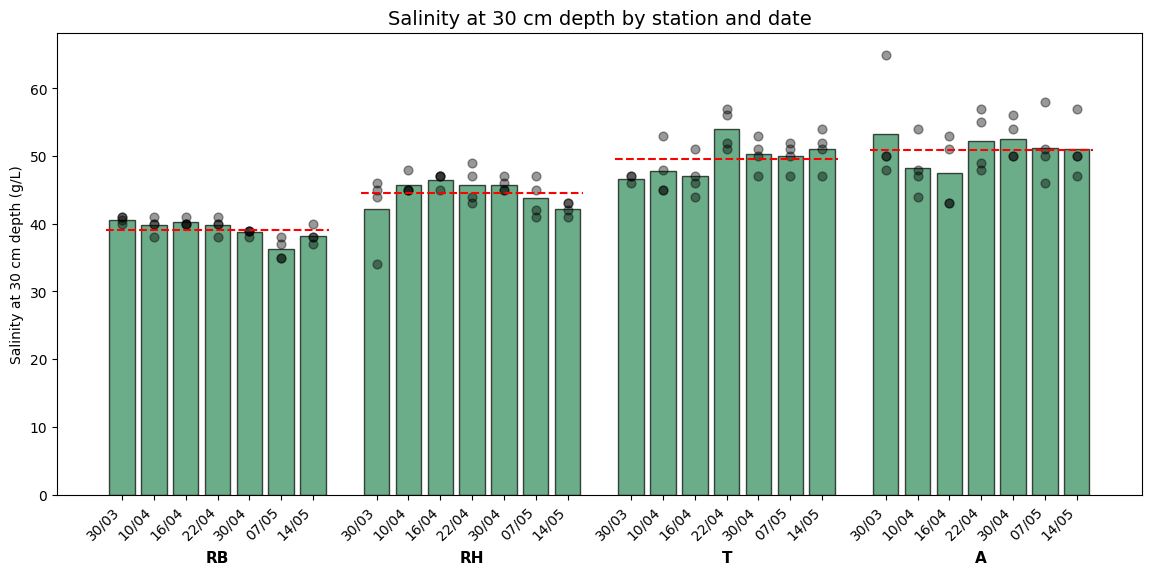

In [4]:
#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations):
    station_df = df[df["Station"]==station]
    group_center = i * (len(dates) + spacing) + (len(dates) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates):
        data = station_df[station_df["Date"] == date]["Salinité à -30cm"]
        if len(data) == 0:
            continue
        x = i * (len(dates) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates) + spacing) - 0.5
    end_x = start_x + len(dates)

    ax.hlines(
        y=station_df["Salinité à -30cm"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates] * len(stations),  
    rotation=45,
    ha='right'
)


ax.set_ylabel("Salinity at 30 cm depth (g/L)")
ax.set_title("Salinity at 30 cm depth by station and date", fontsize=14)

plt.savefig("Plot/salinite_par_station.pdf", dpi=300, bbox_inches='tight')

ANOVA + Tukey for salinity
All data points from all plots and all measurement campaigns were grouped into 4 stations

39.089285714285715
44.57142857142857
49.629629629629626
50.857142857142854
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RB vs. RH: Custom statistical test, P_val:0.000e+00
RH vs. T: Custom statistical test, P_val:0.000e+00
T vs. A: Custom statistical test, P_val:5.509e-01


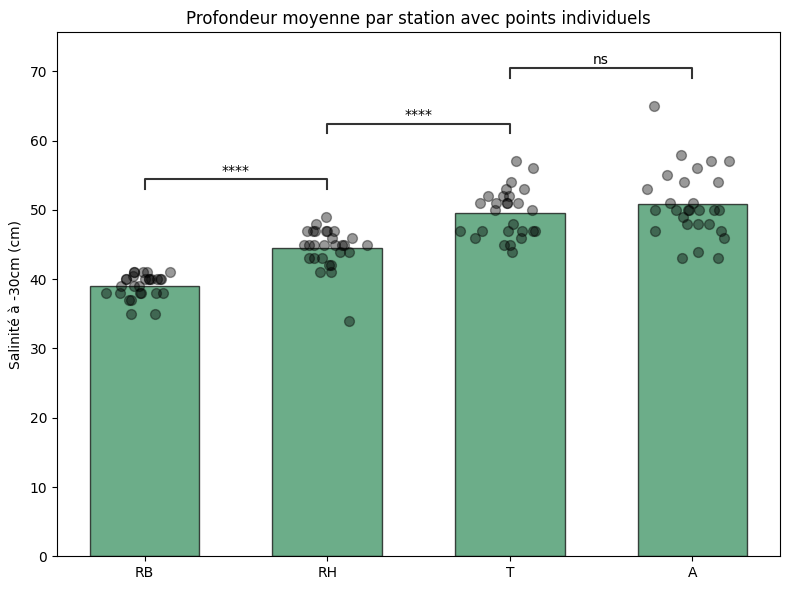

In [6]:


# --- Préparation des données ---
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
stations = ["RB", "RH", "T", "A"]

# Préparer data avec la bonne colonne Station
data = df[["Salinité à -30cm", "Station"]].dropna()

# ANOVA + Tukey
model = ols('Q("Salinité à -30cm") ~ C(Station)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm"],
                          groups=data["Station"],
                          alpha=0.05)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6
x_pos = range(len(stations))

for i, station in enumerate(stations):
    station_mask = df["Parcelle"].str.startswith(station)
    station_df = df[station_mask]
    mean_depth = station_df["Salinité à -30cm"].mean()
    ax.bar(x_pos[i], mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.1, size=len(station_df))
    ax.scatter(x_pos[i] + jitter, station_df["Salinité à -30cm"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations)
ax.set_ylabel("Salinité à -30cm (cm)")
ax.set_title("Profondeur moyenne par station avec points individuels")

# --- Statannotations ---
# Comparaisons voulues
comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm")
annotator.configure(test=None, text_format='star')  # Pas de test automatique

# On injecte les p-values du test Tukey dans l'annotator
pvalues = []
for pair in comparisons:
    # Tukey retourne les p-values par paire dans tukey.summary()
    # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
    for row in tukey._results_table.data[1:]:
        if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
            pvalues.append(float(row[3]))
            break

annotator.set_pvalues(pvalues)
annotator.annotate()
plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [7]:

# Sort results
raw_results = tukey._results_table.data[1:]  
order_index = {"RB": 0, "RH": 1, "T": 2, "A": 3}

results_ordered = []
for row in raw_results:
    g1, g2, meandiff, p_adj, lower, upper, reject = row
    i1, i2 = order_index[g1], order_index[g2]

    if i1 > i2:
        g1, g2 = g2, g1
        meandiff = -meandiff
        lower, upper = -upper, -lower
        lower, upper = min(lower, upper), max(lower, upper)  # sécuriser bornes

    results_ordered.append((g1, g2, meandiff, p_adj, lower, upper, reject))


results_sorted = sorted(results_ordered, key=lambda row: (order_index[row[0]], order_index[row[1]]))

# Display results
custom_columns = ["Station 1", "Station 2", "Mean Difference (g/L)", "p-value", "Lower (g/L)", "Upper (g/L)", "Reject"]

print("\nTukey test")
print("{:<10} {:<10} {:>12} {:>12} {:>15} {:>12} {:>12}".format(*custom_columns))
for row in results_sorted:
    g1, g2, meandiff, p_adj, lower, upper, reject = row
    print("{:<10} {:<10} {:>12.6f} {:>22.6f} {:>12.6f} {:>12.6f} {:>12}".format(
        g1, g2, meandiff, p_adj, lower, upper, str(reject)))



Tukey test
Station 1  Station 2  Mean Difference (g/L)      p-value     Lower (g/L)  Upper (g/L)       Reject
RB         RH             5.482100               0.000000     3.081300     7.882900         True
RB         T             10.540300               0.000000     8.117400    12.963300         True
RB         A             11.767900               0.000000     9.367100    14.168700         True
RH         T              5.058200               0.000000     2.635300     7.481100         True
RH         A              6.285700               0.000000     3.884900     8.686500         True
T          A              1.227500               0.550900    -1.195400     3.650400        False


Plot groundwater depth as a function of date, grouped by station

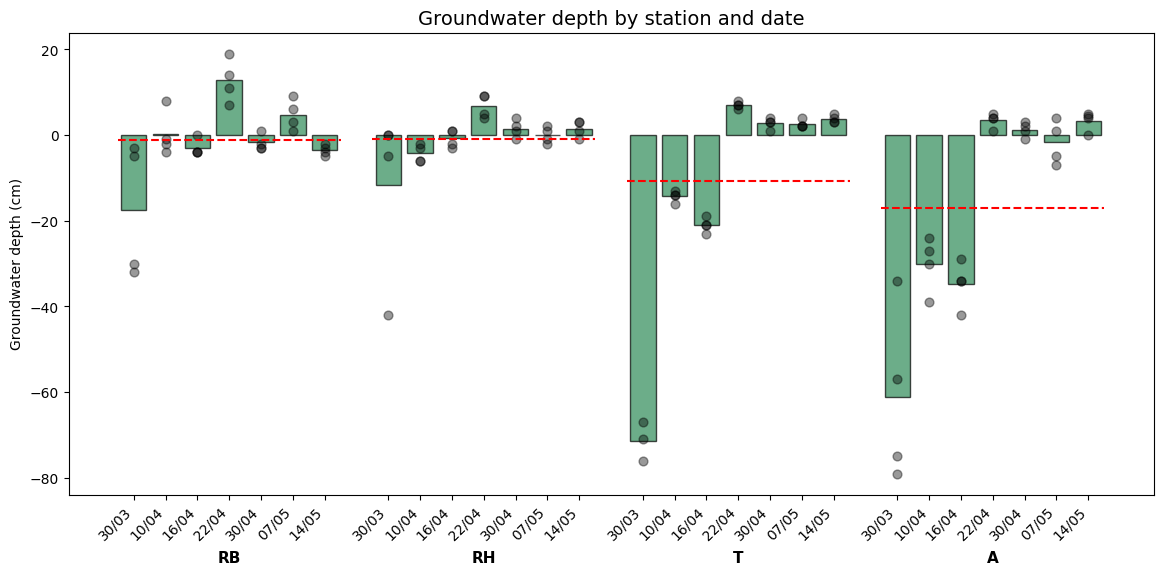

In [8]:

#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations):
    station_df = df[df["Station"]==station]
    group_center = i * (len(dates) + spacing) + (len(dates) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates):
        data = station_df[station_df["Date"] == date]["Profondeur de la nappe"]
        if len(data) == 0:
            continue
        x = i * (len(dates) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates) + spacing) - 0.5
    end_x = start_x + len(dates)

    ax.hlines(
        y=station_df["Profondeur de la nappe"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates] * len(stations),  
    rotation=45,
    ha='right'
)


ax.set_ylabel("Groundwater depth (cm)")
ax.set_title("Groundwater depth by station and date", fontsize=14)

plt.savefig("Plot/profondeur_par_station.pdf", dpi=300, bbox_inches='tight')

-3.0
-0.75
-21.0
-34.75
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RB vs. RH: Custom statistical test, P_val:7.477e-01
RH vs. T: Custom statistical test, P_val:0.000e+00
T vs. A: Custom statistical test, P_val:2.000e-04


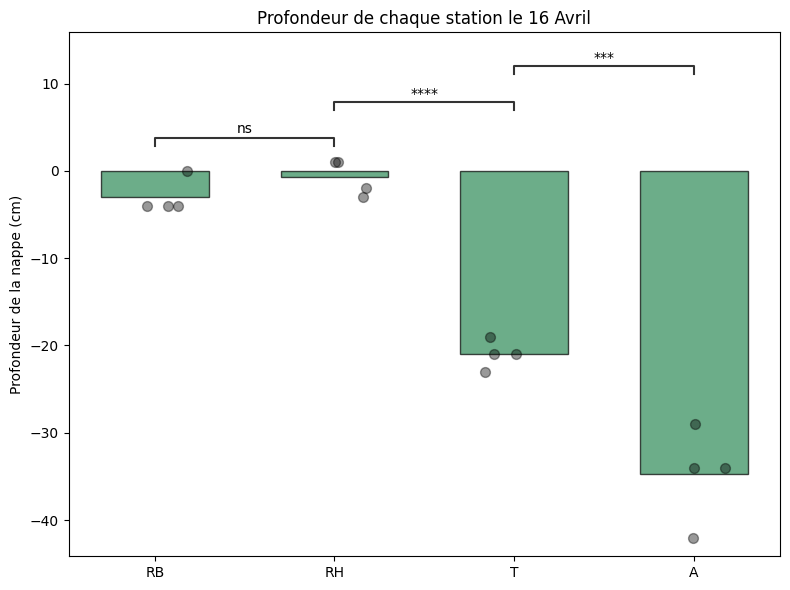

In [12]:


stations = ["RB", "RH", "T", "A"]

# Préparer data avec la bonne colonne Station
data = df[df["Date"]=="16-04-2025"][["Profondeur de la nappe", "Station"]].dropna()

# ANOVA + Tukey
model = ols('Q("Profondeur de la nappe") ~ C(Station)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=data["Profondeur de la nappe"],
                          groups=data["Station"],
                          alpha=0.05)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6

for i, station in enumerate(stations):
    df_filtered = data[data["Station"]==station]["Profondeur de la nappe"]
    mean_depth = df_filtered.mean()
    ax.bar(i, mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    print(mean_depth)   
    jitter = np.random.normal(loc=0, scale=0.1, size=len(df_filtered))
    ax.scatter(i + jitter, df_filtered, color='black', alpha=0.4, s=50)
ax.set_xticks(x_pos)
ax.set_xticklabels(stations)
ax.set_ylabel("Profondeur de la nappe (cm)")
ax.set_title("Profondeur de chaque station le 16 Avril")

# --- Statannotations ---
# Comparaisons voulues
comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

annotator = Annotator(ax, comparisons, data=data, x="Station", y="Profondeur de la nappe")
annotator.configure(test=None, text_format='star')  # Pas de test automatique

# On injecte les p-values du test Tukey dans l'annotator
pvalues = []
for pair in comparisons:
    # Tukey retourne les p-values par paire dans tukey.summary()
    # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
    for row in tukey._results_table.data[1:]:
        if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
            pvalues.append(float(row[3]))
            break

annotator.set_pvalues(pvalues)
annotator.annotate()
plt.savefig("Plot/profondeur_anova_tukey.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [10]:
# Ordre imposé des groupes
order_index = {"RB": 0, "RH": 1, "T": 2, "A": 3}

# Extraction brute des résultats Tukey
raw_results = tukey._results_table.data[1:]  # sauter l'en-tête

# Réorganisation et inversion éventuelle des résultats
results_ordered = []
for row in raw_results:
    g1, g2, meandiff, p_adj, lower, upper, reject = row
    i1, i2 = order_index[g1], order_index[g2]

    if i1 > i2:
        # Inverser la paire pour forcer g1 < g2 selon l'ordre voulu
        g1, g2 = g2, g1
        meandiff = -meandiff
        lower, upper = -upper, -lower
        lower, upper = min(lower, upper), max(lower, upper)  # sécuriser bornes

    results_ordered.append((g1, g2, meandiff, p_adj, lower, upper, reject))

# Tri final selon ordre imposé
results_sorted = sorted(results_ordered, key=lambda row: (order_index[row[0]], order_index[row[1]]))

# Affichage
custom_columns = ["Station 1", "Station 2", "Différence", "p-valeur", "IC bas", "IC haut", "Résultat"]

print("\nTest de Tukey")
print("{:<10} {:<10} {:>12} {:>12} {:>12} {:>12} {:>12}".format(*custom_columns))

for row in results_sorted:
    g1, g2, meandiff, p_adj, lower, upper, reject = row
    print("{:<10} {:<10} {:>12.6f} {:>12.6f} {:>12.6f} {:>12.6f} {:>12}".format(
        g1, g2, meandiff, p_adj, lower, upper, str(reject)))



Test de Tukey
Station 1  Station 2    Différence     p-valeur       IC bas      IC haut     Résultat
RB         RH             2.250000     0.747700    -4.374800     8.874800        False
RB         T            -18.000000     0.000000   -24.624800   -11.375200         True
RB         A            -31.750000     0.000000   -38.374800   -25.125200         True
RH         T            -20.250000     0.000000   -26.874800   -13.625200         True
RH         A            -34.000000     0.000000   -40.624800   -27.375200         True
T          A            -13.750000     0.000200   -20.374800    -7.125200         True


In [11]:
df2 = pd.read_csv("Data/Salinité + Hauteur d’eau + pH + redox + OD - paramètres environnementaux  - Feuille 6.csv")  # Remplace par le nom exact de ton fichier
# df2 = df2.iloc[:, 1:]
df2["pH (piézo)"] = df2["pH (piézo)"].astype(str).str.replace(',', '.')
df2["DO (piézo)"] = df2["DO (piézo)"].astype(str).str.replace(',', '.')
df2["redox (piézo)"] = df2["redox (piézo)"].astype(str).str.replace(',', '.')
df2["pH (sol)"] = df2["pH (sol)"].astype(str).str.replace(',', '.')
df2["DO (sol)"] = df2["DO (sol)"].astype(str).str.replace(',', '.')
df2["redox (sol)"] = df2["redox (sol)"].astype(str).str.replace(',', '.')
df2["Date"] = pd.to_datetime(df2["Date"], dayfirst=True)
df2["Station"] = df2["Parcelle"].str.extract(r'([A-Z]+)')

df2["pH (piézo)"] = df2["pH (piézo)"].astype(float)
df2["DO (piézo)"] = df2["DO (piézo)"].astype(float)
df2["redox (piézo)"] = df2["redox (piézo)"].astype(float)
df2["pH (sol)"] = df2["pH (sol)"].astype(float)
df2["DO (sol)"] = df2["DO (sol)"].astype(float)
df2["redox (sol)"] = df2["redox (sol)"].astype(float)


ValueError: could not convert string to float: '/'

In [ ]:
print(df2["pH (piézo)"].dtype)


float64


Text(0.5, 1.0, 'Profondeur moyenne par station avec points individuels')

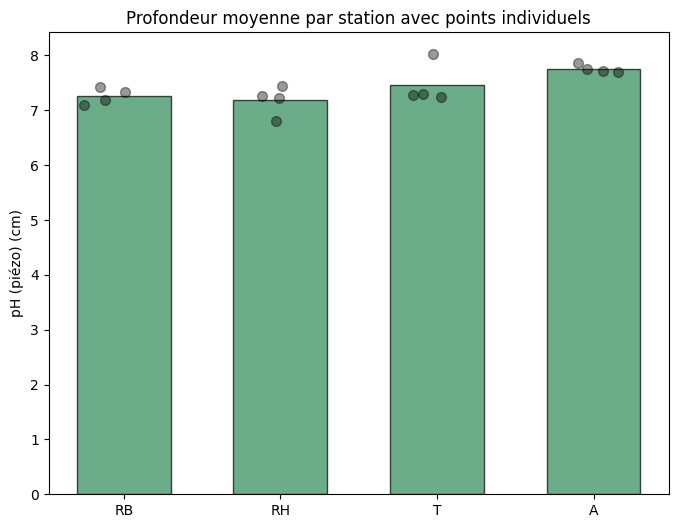

In [ ]:
stations = ["RB", "RH", "T", "A"]

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6
# x_pos = range(len(stations))

for i, station in enumerate(stations):
    station_df = df2[df2["Station"]==station]
    mean_depth = station_df["pH (piézo)"].mean()
    ax.bar(x_pos[i], mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')

    jitter = np.random.normal(loc=0, scale=0.1, size=len(station_df))
    ax.scatter(x_pos[i] + jitter, station_df["pH (piézo)"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations)
ax.set_ylabel("pH (piézo) (cm)")
ax.set_title("Profondeur moyenne par station avec points individuels")


# --- Statannotations ---
# Comparaisons voulues
# comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

# annotator = Annotator(ax, comparisons, data=data, x="Station", y="pH (piézo)")
# annotator.configure(test=None, text_format='star')  # Pas de test automatique

# # On injecte les p-values du test Tukey dans l'annotator
# pvalues = []
# for pair in comparisons:
#     # Tukey retourne les p-values par paire dans tukey.summary()
#     # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
#     for row in tukey._results_table.data[1:]:
#         if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
#             pvalues.append(float(row[3]))
#             break

# annotator.set_pvalues(pvalues)
# annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
# plt.tight_layout()
# plt.show()


In [18]:
df = df.drop(columns=['Station'])

# 2. Calculer la moyenne de la salinité par parcelle (sur toutes les dates)
salinite_moyenne = df.groupby('Parcelle', as_index=False)['Salinité à -30cm'].mean()

# 3. Extraire les valeurs de profondeur du 16 avril 2025
profondeur_16avril = df[df['Date'] == '2025-04-16'][['Parcelle', 'Profondeur de la nappe']]

# 4. Fusionner les deux tableaux sur la colonne 'Parcelle'
df_final = pd.merge(profondeur_16avril, salinite_moyenne, on='Parcelle', how='inner')

In [19]:
df_final

,Parcelle,Profondeur de la nappe,Salinité à -30cm
0,RB1,0.0,39.142857
1,RB2,-4.0,38.500000
2,RB3,-4.0,39.428571
3,RB4,-4.0,39.285714
4,RH1,-3.0,44.142857
5,RH2,1.0,42.428571
6,RH3,-2.0,46.428571
7,RH4,1.0,45.285714
8,T1,-19.0,51.714286
9,T2,-21.0,48.714286
